# Modules

In [1]:
%load_ext autoreload
%autoreload 2

import json
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import pearsonr, wilcoxon

from gait.constants import *
from gait.evaluation import *
from gait.pdh_specific import plot_coefs, plot_n_subjects

d_plot_params = {
    'font.family': 'serif',
    'font.size': 18,
    'axes.labelsize': 20,
    'axes.titlesize': 22,
    'xtick.labelsize': 16,
    'ytick.labelsize': 16,
    'legend.fontsize': 14,
    'legend.title_fontsize': 16,
}

sns.set(rc=d_plot_params)
sns.set_theme(style='white', rc=d_plot_params)

# Constants

In [2]:
filename_predictions = 'd_performance_filtering_gait.json'
asd_model_selected = LOGISTIC_REGRESSION

# Load

In [3]:
with open(os.path.join(PDH_PATH_ARM_ACTIVITY_PREDICTIONS, filename_predictions), 'r') as f:
    d_performance = json.load(f)

with open(os.path.join(PDH_PATH_ARM_ACTIVITY_PREDICTIONS, LOGISTIC_REGRESSION, 'importances.txt')) as f:
    coefs_lr = f.read()

with open(os.path.join(PDH_PATH_ARM_ACTIVITY_PREDICTIONS, RANDOM_FOREST, 'importances.txt')) as f:
    coefs_rf = f.read()

# Figures and tables

#### Feature coefficients

Logistic regression coefficients

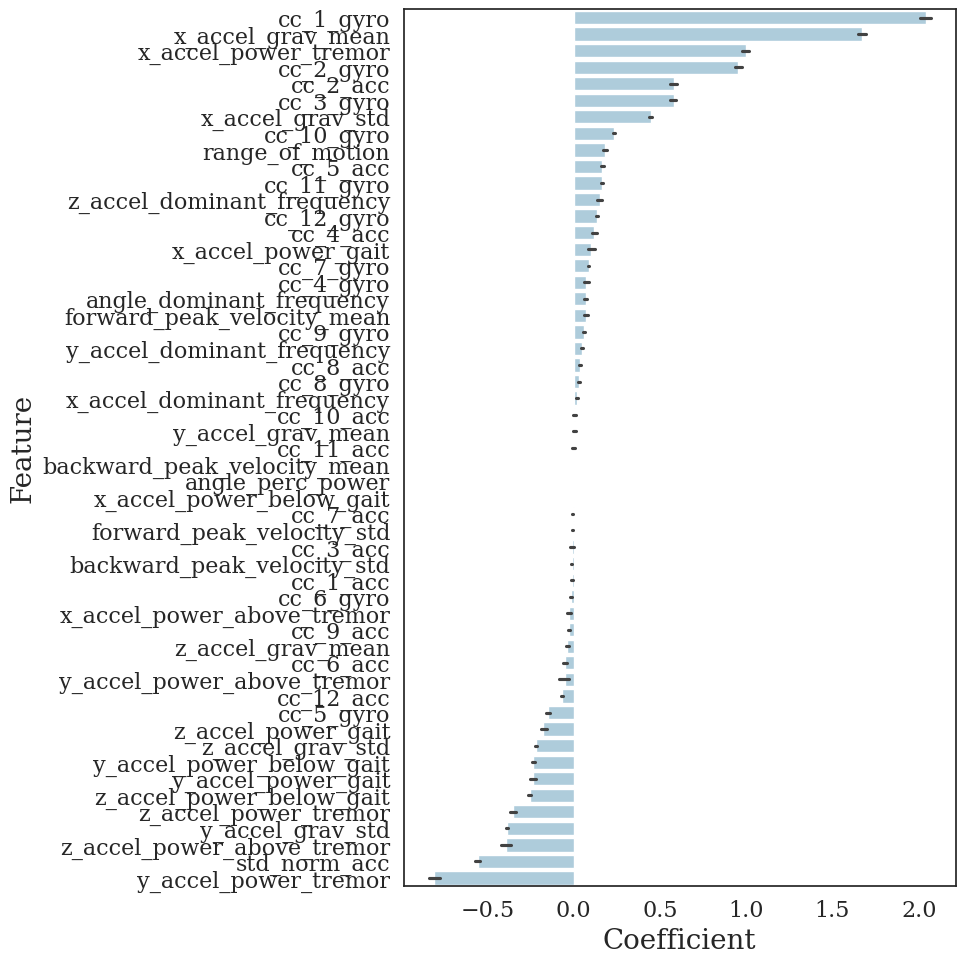

In [5]:
plot_coefs(coefs_lr, LOGISTIC_REGRESSION, (10,10))

Random forest impurity score

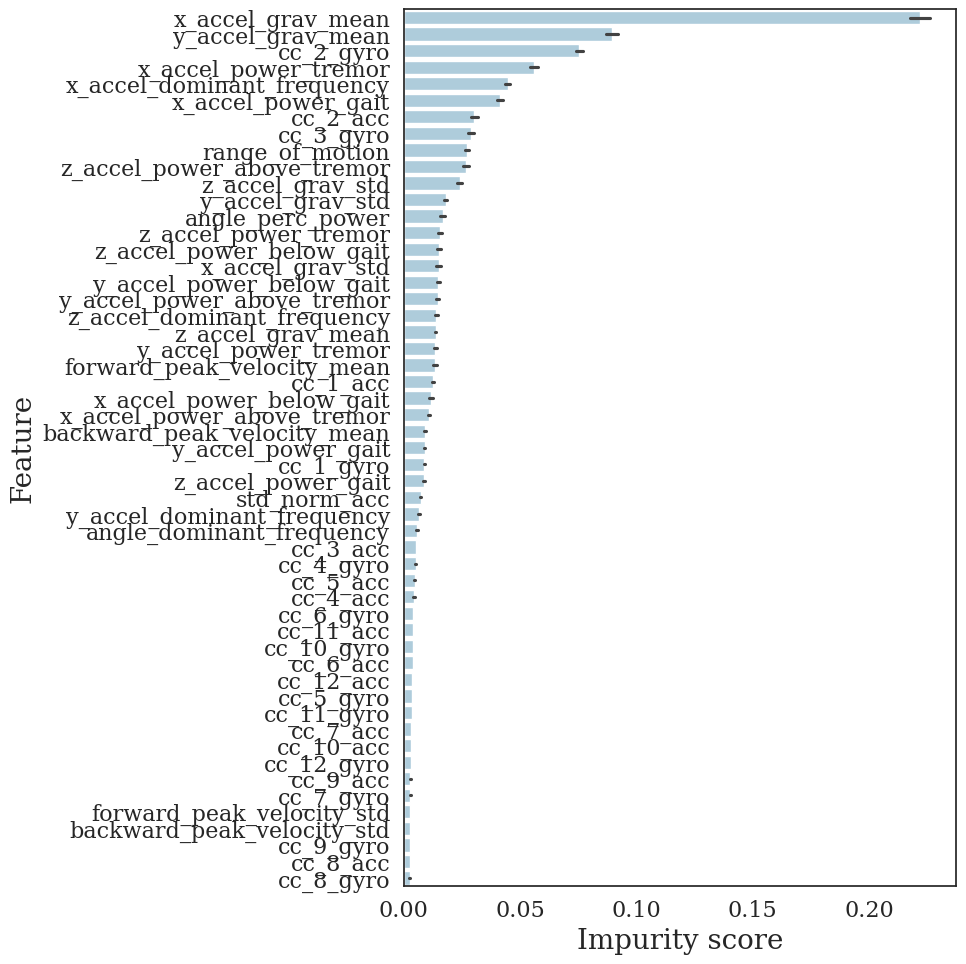

In [6]:
plot_coefs(coefs_rf, RANDOM_FOREST, (10,10))

#### Dataset size

In [8]:
df_size = pd.DataFrame()

for segment_duration in D_SEGMENT_DURATIONS.keys():
    for med_stage in ['pre', 'post']:
        l_segment_durations = [d_performance[x][asd_model_selected]['MAS'][med_stage]['segment_duration'][segment_duration]['seconds_total']/60 for x in L_PD_IDS if segment_duration in d_performance[x][asd_model_selected]['MAS'][med_stage]['segment_duration'].keys()]

        df_size = pd.concat([df_size, pd.DataFrame([
            med_stage,
            segment_duration,
            f"{np.round(np.mean(l_segment_durations),1)} ({np.round(np.std(l_segment_durations),1)})",
        ]).T], axis=0).reset_index(drop=True)

    l_segment_durations = [d_performance[x][asd_model_selected]['MAS']['HC']['segment_duration'][segment_duration]['seconds_total']/60 for x in L_HC_IDS if segment_duration in d_performance[x][asd_model_selected]['MAS']['HC']['segment_duration'].keys()]

    df_size = pd.concat([df_size, pd.DataFrame([
        'HC',
        segment_duration,
        f"{np.round(np.mean(l_segment_durations),1)} ({np.round(np.std(l_segment_durations),1)})",
    ]).T], axis=0).reset_index(drop=True)

df_size = pd.concat([df_size, pd.DataFrame([
    'HC',
    'total',
    f"{np.round(np.mean([d_performance[x][asd_model_selected]['MAS']['HC']['seconds_total']/60 for x in L_HC_IDS]),1)} ({np.round(np.std([d_performance[x][asd_model_selected]['MAS']['HC']['seconds_total']/60 for x in L_HC_IDS]),1)})"
]).T])

mins_non_gait = [d_performance[x][asd_model_selected]['MAS']['HC']['seconds_total']/60 - np.sum([d_performance[x][asd_model_selected]['MAS']['HC']['segment_duration'][segment_duration]['seconds_total']/60 for segment_duration in d_performance[x][asd_model_selected]['MAS']['HC']['segment_duration'].keys()]) for x in L_HC_IDS]

df_size = pd.concat([df_size, pd.DataFrame([
    'HC',
    'non_gait',
    f"{np.round(np.mean(mins_non_gait),2)} ({np.round(np.std(mins_non_gait),1)})"
]).T])

for med_stage in ['pre', 'post']:
    mins_non_gait = mins_non_gait = [d_performance[x][asd_model_selected]['MAS'][med_stage]['seconds_total']/60 - np.sum([d_performance[x][asd_model_selected]['MAS'][med_stage]['segment_duration'][segment_duration]['seconds_total']/60 for segment_duration in d_performance[x][asd_model_selected]['MAS'][med_stage]['segment_duration'].keys()]) for x in L_PD_IDS]
    df_size = pd.concat([df_size, pd.DataFrame([
        med_stage,
        'non_gait',
        f"{np.round(np.mean(mins_non_gait),2)} ({np.round(np.std(mins_non_gait),1)})"
    ]).T])

    df_size = pd.concat([df_size, pd.DataFrame([
        med_stage,
        'total',
        f"{np.round(np.mean([d_performance[x][asd_model_selected]['MAS'][med_stage]['seconds_total']/60 for x in L_PD_IDS]),1)} ({np.round(np.std([d_performance[x][asd_model_selected]['MAS'][med_stage]['seconds_total']/60 for x in L_PD_IDS]),1)})"
    ]).T])
    
df_size.columns = ['Medication stage', 'Gait sequence duration', 'Mean (SD) number of minutes']

print("Table 5: Mean (SD) minutes of predicted gait stratified by gait sequence duration and medication stage")
df_size.pivot(index='Gait sequence duration', columns='Medication stage', values=['Mean (SD) number of minutes']).reindex(['short', 'moderately_long', 'long', 'very_long', 'non_gait', 'total'])

Table 5: Mean (SD) minutes of predicted gait stratified by gait sequence duration and medication stage


Mean (SD) number of minutes                        
Medication stage                                HC        post         pre
Gait sequence duration                                                    
short                                    1.5 (0.5)   0.4 (0.2)   0.7 (0.3)
moderately_long                          2.0 (0.6)   1.0 (0.5)   1.6 (0.8)
long                                     1.5 (1.2)   0.9 (0.5)   1.1 (0.6)
very_long                               14.2 (5.3)   8.3 (5.3)   8.3 (5.3)
non_gait                               11.98 (6.0)  3.54 (2.5)  4.07 (2.4)
total                                   31.1 (9.6)  14.0 (6.9)  15.7 (6.2)

## Selecting a classifier
Split by medication state for PD (pre-med, post-med)

In [9]:
df_performance = pd.DataFrame()

for asd_model in [LOGISTIC_REGRESSION, RANDOM_FOREST]:
    for med_stage in ['pre', 'post']:
        for affected_side in [MOST_AFFECTED_SIDE, LEAST_AFFECTED_SIDE]:
            sens = [d_performance[x][asd_model][affected_side][med_stage]['sens'] for x in L_PD_IDS]
            spec = [d_performance[x][asd_model][affected_side][med_stage]['spec'] for x in L_PD_IDS]
            auc = [d_performance[x][asd_model][affected_side][med_stage]['auc'] for x in L_PD_IDS]

            df_performance = pd.concat([df_performance, pd.DataFrame([asd_model,
                                                                    f'{med_stage} {affected_side}',
                                                                    f"{np.round(np.mean(sens),2)} ({np.round(np.std(sens),2)})",
                                                                    f"{np.round(np.mean(spec),2)} ({np.round(np.std(spec),2)})",
                                                                    f"{np.round(np.mean(auc),2)} ({np.round(np.std(auc),2)})"
                                                                    ]).T], axis=0).reset_index(drop=True)
        
df_performance.columns = ['Classifier', 'Med stage', 'Sensitivity', 'Specificity', 'AUC']

print("Table 6: Stratified performance of the random forest (rf) and logistic regression (lr) classifiers.")
df_performance.pivot(index='Med stage', columns='Classifier', values=['Sensitivity', 'Specificity', 'AUC']).sort_index(ascending=False)

Table 6: Stratified performance of the random forest (rf) and logistic regression (lr) classifiers.


Sensitivity               Specificity                       AUC  \
Classifier       logreg           rf       logreg           rf       logreg   
Med stage                                                                     
pre MAS     0.92 (0.05)  0.96 (0.03)   0.7 (0.25)  0.62 (0.31)  0.92 (0.08)   
pre LAS     0.92 (0.09)   0.94 (0.1)  0.76 (0.18)  0.67 (0.23)  0.93 (0.05)   
post MAS    0.91 (0.09)  0.93 (0.08)   0.81 (0.2)  0.78 (0.18)  0.94 (0.05)   
post LAS    0.86 (0.15)  0.87 (0.17)  0.78 (0.25)  0.72 (0.29)   0.92 (0.1)   

                         
Classifier           rf  
Med stage                
pre MAS      0.9 (0.14)  
pre LAS      0.92 (0.1)  
post MAS    0.94 (0.05)  
post LAS     0.9 (0.15)

In [11]:
# statistical difference between logreg and rf
med_stage = 'pre'
affected_side = 'MAS'

l_logreg_baccs = [(d_performance[x][LOGISTIC_REGRESSION][affected_side][med_stage]['sens'] + d_performance[x][LOGISTIC_REGRESSION][affected_side][med_stage]['spec'])/2 for x in L_PD_IDS]
l_rf_baccs = [(d_performance[x][RANDOM_FOREST][affected_side][med_stage]['sens'] + d_performance[x][RANDOM_FOREST][affected_side][med_stage]['spec'])/2 for x in L_PD_IDS]

p_value = wilcoxon(
    l_logreg_baccs, 
    l_rf_baccs
)[1]
print(f"Logistic regression bacc: {np.round(np.mean(l_logreg_baccs),2)}")
print(f"Random forest bacc: {np.round(np.mean(l_rf_baccs),2)}")
print(f"P-value: {p_value}")

# statistical difference between pre-med and post-med
l_pre_specs = [d_performance[x][asd_model_selected][affected_side]['pre']['spec'] for x in L_PD_IDS]
l_post_specs = [d_performance[x][asd_model_selected][affected_side]['post']['spec'] for x in L_PD_IDS]

p_value = wilcoxon(
    l_pre_specs, 
    l_post_specs
)[1]

print(f"\n--- Logistic regression ---")
print(f"Pre-med specificity: {np.round(np.mean(l_pre_specs),2)}")
print(f"Post-med specificity: {np.round(np.mean(l_post_specs),2)}")
print(f"P-value: {p_value}")

Logistic regression bacc: 0.81
Random forest bacc: 0.79
P-value: 0.07942724227905273

--- Logistic regression ---
Pre-med specificity: 0.7
Post-med specificity: 0.81
P-value: 0.018956661224365234


## Effect of behavior

#### Arm activities

Sensitivity of arm activities


C:\Users\erik_\AppData\Local\Temp\ipykernel_7240\1700090703.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=d_arm_activity_performance, ax=ax, color=COLOR_PALETTE_FIRST_COLOR, palette=palette_as, orient='h')


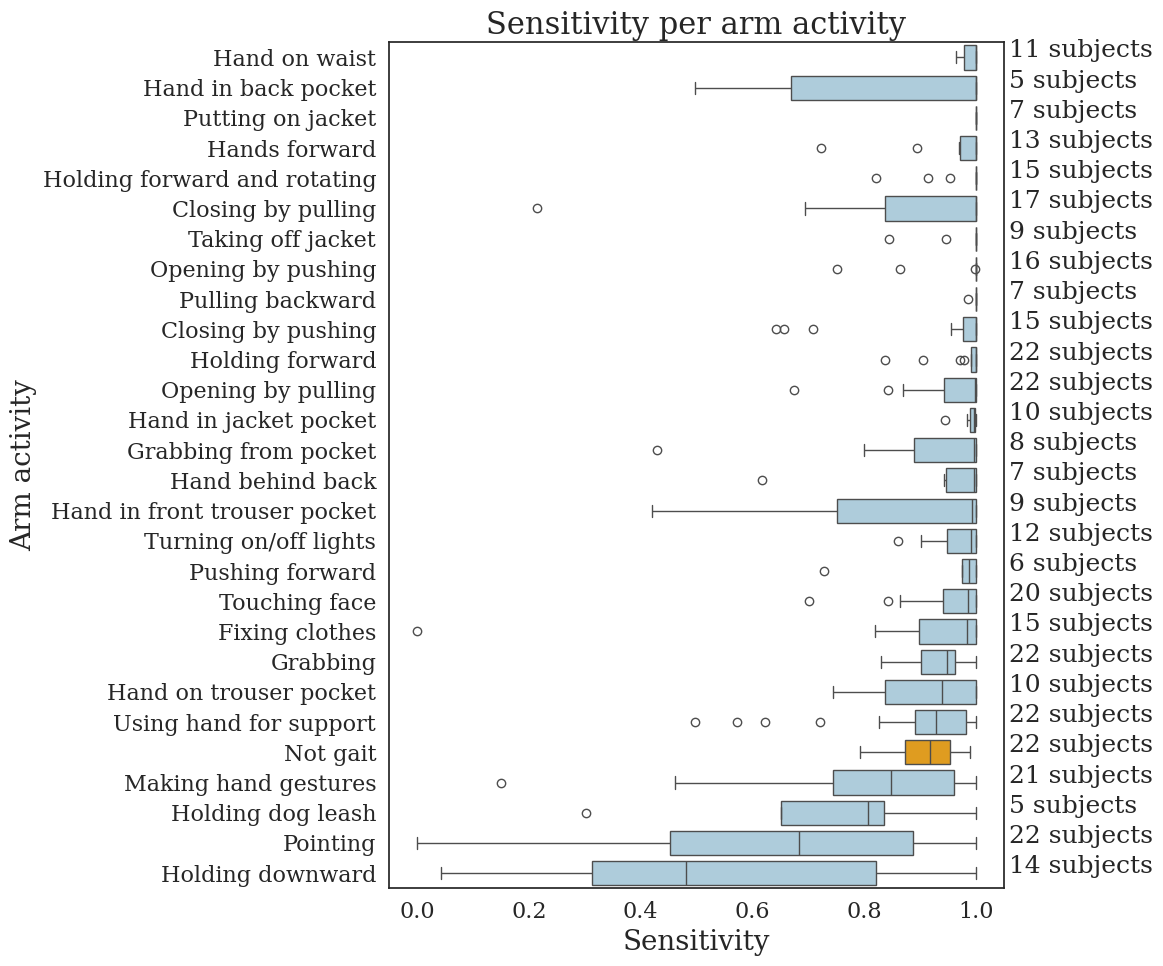

In [13]:
metric = 'sens'
l_arm_activities = list(set([x for y in [list(d_performance[x][asd_model_selected]['arm_activities'].keys()) for x in L_PD_IDS] for x in y]))

d_arm_activity_performance = {}

print("Sensitivity of arm activities")
for arm_activity in [x for x in l_arm_activities if 'Gait' not in x and 'Walking' not in x and x != 'Transition']:
    l_arm_activity_sens = [d_performance[x][asd_model_selected]['arm_activities'][arm_activity][metric] for x in L_PD_IDS if arm_activity in d_performance[x][asd_model_selected]['arm_activities']]
    if len(l_arm_activity_sens) >= 5:
        d_arm_activity_performance[arm_activity] = l_arm_activity_sens

d_arm_activity_performance = {k: v for k, v in sorted(d_arm_activity_performance.items(), key=lambda item: np.median(item[1]), reverse=True)}

palette_as = {label: 'orange' if label == 'Not gait' else COLOR_PALETTE_FIRST_COLOR for label in d_arm_activity_performance.keys()}

fig, ax = plt.subplots(figsize=(12, 10))

sns.boxplot(data=d_arm_activity_performance, ax=ax, color=COLOR_PALETTE_FIRST_COLOR, palette=palette_as, orient='h')

plot_n_subjects(d_performance=d_arm_activity_performance, x_loc=1.06, ax=ax)

ax.set_xlabel(D_METRIC_MAP[metric])
ax.set_ylabel('Arm activity')
ax.set_title('Sensitivity per arm activity')
plt.tight_layout()
plt.show()

#### Sequence duration

Specificity per gait segment duration
short: 0.36 +/- 0.29
moderately_long: 0.59 +/- 0.22
long: 0.51 +/- 0.24
very_long: 0.78 +/- 0.29


C:\Users\erik_\AppData\Local\Temp\ipykernel_7240\1079540876.py:44: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(['short\n[$<$5s]', 'moderately long\n[5-10s]', 'long\n[10-20s]', 'very long\n[$>$20s]'])


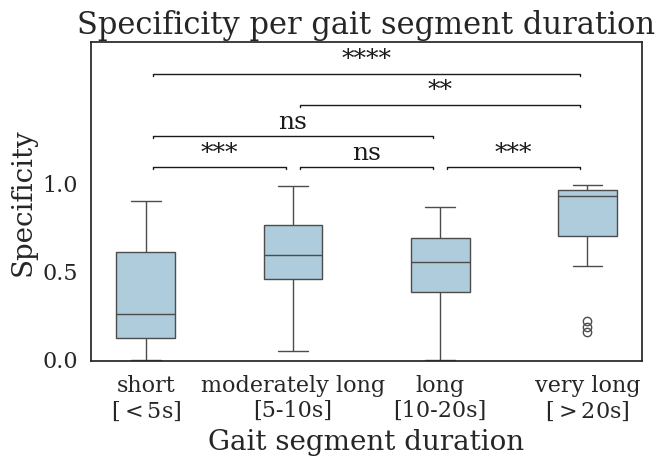

In [17]:
metric = 'spec'
affected_side = MOST_AFFECTED_SIDE
pre_or_post = 'pre'
l_segment_durations = list(D_SEGMENT_DURATIONS.keys())

d_segment_performance = {}

l_ids = [x for x in L_PD_IDS if all([y in d_performance[x][asd_model_selected][affected_side][pre_or_post]['segment_duration'].keys() for y in ['short', 'moderately_long', 'long', 'very_long']]) and all([~np.isnan(d_performance[x][asd_model_selected][affected_side][pre_or_post]['segment_duration'][y][metric]) for y in ['short', 'moderately_long', 'long', 'very_long']])]

print(f"{D_METRIC_MAP[metric]} per gait segment duration")
for segment_duration in l_segment_durations:
    d_segment_performance[segment_duration] = [d_performance[x][asd_model_selected][affected_side][pre_or_post]['segment_duration'][segment_duration][metric] for x in l_ids if segment_duration in d_performance[x][asd_model_selected][affected_side][pre_or_post]['segment_duration'].keys()]

    print(f"{segment_duration}: {np.round(np.nanmean(d_segment_performance[segment_duration]),2)} +/- {np.round(np.nanstd(d_segment_performance[segment_duration]),2)}")

# d_segment_performance = {k: v for k, v in sorted(d_segment_performance.items(), key=lambda item: np.median(item[1]), reverse=False)}

fig, ax = plt.subplots(figsize=(7, 5))

sns.boxplot(data=d_segment_performance, width=0.4, ax=ax, color=COLOR_PALETTE_FIRST_COLOR)
gap = 0.05

pvalue = calculate_pvalue(d_segment_performance['short'], d_segment_performance['moderately_long'], 'wilcoxon')[1]
plot_significance(ax=ax, x_min=0.05, x_max=0.95, pvalue=pvalue, y_min_significance=1.05, gap=gap, row=1, text_size=d_plot_params['font.size'])

pvalue = calculate_pvalue(d_segment_performance['moderately_long'], d_segment_performance['long'], 'wilcoxon')[1]
plot_significance(ax=ax, x_min=1.05, x_max=1.95, pvalue=pvalue, y_min_significance=1.05, gap=gap, row=1, text_size=d_plot_params['font.size'])

pvalue = calculate_pvalue(d_segment_performance['long'], d_segment_performance['very_long'], 'wilcoxon')[1]
plot_significance(ax=ax, x_min=2.05, x_max=2.95, pvalue=pvalue, y_min_significance=1.05, gap=gap, row=1, text_size=d_plot_params['font.size'])

pvalue = calculate_pvalue(d_segment_performance['short'], d_segment_performance['long'], 'wilcoxon')[1]
plot_significance(ax=ax, x_min=0.05, x_max=1.95, pvalue=pvalue, y_min_significance=1.22, gap=gap, row=1, text_size=d_plot_params['font.size'])

pvalue = calculate_pvalue(d_segment_performance['moderately_long'], d_segment_performance['very_long'], 'wilcoxon')[1]
plot_significance(ax=ax, x_min=1.05, x_max=2.95, pvalue=pvalue, y_min_significance=1.39, gap=gap, row=1, text_size=d_plot_params['font.size'])

pvalue = calculate_pvalue(d_segment_performance['short'], d_segment_performance['very_long'], 'wilcoxon')[1]
plot_significance(ax=ax, x_min=0.05, x_max=2.95, pvalue=pvalue, y_min_significance=1.56, gap=gap, row=1, text_size=d_plot_params['font.size'])

ax.set_ylabel(D_METRIC_MAP[metric])
ax.set_xlabel('Gait segment duration')
ax.set_ylim([-0.01,1.8])
ax.set_xticklabels(['short\n[$<$5s]', 'moderately long\n[5-10s]', 'long\n[10-20s]', 'very long\n[$>$20s]'])
ax.set_title('Specificity per gait segment duration')

for i in range(1,7):
    ax.yaxis.get_major_ticks()[-1*i].label1.set_visible(False)

plt.tight_layout()
plt.show()

## Effect of PD

Specificity difference between pre-med and post-med after correcting for gait segment duration prevalence
System: uncorrected, p-value: 0.018956661224365234
System: corrected, p-value: 0.12067747116088867


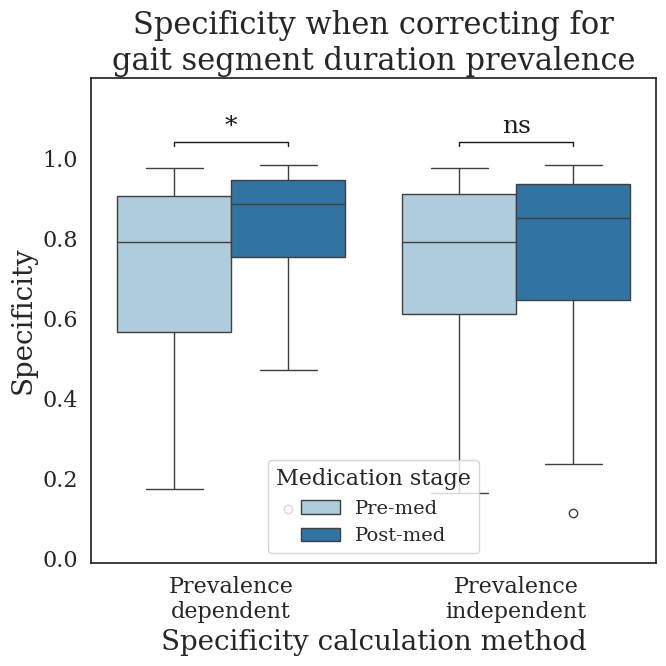

In [20]:
metric = 'spec'
df_sens_prevalence = pd.DataFrame()

for subject in L_PD_IDS:
    for med_stage in ['pre', 'post']:
        df_sens_prevalence = pd.concat([df_sens_prevalence, pd.DataFrame([subject, med_stage, 'uncorrected', d_performance[subject][asd_model_selected]['MAS'][med_stage][metric]]).T], axis=0).reset_index(drop=True)
        df_sens_prevalence = pd.concat([df_sens_prevalence, pd.DataFrame([subject, med_stage, 'corrected', d_performance[subject][asd_model_selected]['MAS'][med_stage][f'{metric}_corrected']]).T], axis=0).reset_index(drop=True)

df_sens_prevalence.columns = [ID_COLNAME, 'pre_or_post', 'system', metric]

fig, ax = plt.subplots(figsize=(7,7))

sns.boxplot(data=df_sens_prevalence, x='system', y=metric, hue='pre_or_post', order=['uncorrected', 'corrected'], palette=COLOR_PALETTE)

print("Specificity difference between pre-med and post-med after correcting for gait segment duration prevalence")
for j, system in enumerate(['uncorrected', 'corrected']):
    vals_1 = list(df_sens_prevalence.loc[(df_sens_prevalence['system']==system) & (df_sens_prevalence['pre_or_post']=='pre'), metric].values)
    vals_2 = list(df_sens_prevalence.loc[(df_sens_prevalence['system']==system) & (df_sens_prevalence['pre_or_post']=='post'), metric].values)

    pvalue = calculate_pvalue(vals_1, vals_2, 'wilcoxon')[1]
    plot_significance(ax=ax, x_min=j+0.2, x_max=j-0.2, pvalue=pvalue, y_min_significance=1, gap=0.01, row=1, text_size=d_plot_params['font.size'])

    print(f"System: {system}, p-value: {pvalue}")

ax.set_ylim([-0.01,1.2])
ax.set_xticks(ax.get_xticks(), ['Prevalence\ndependent', 'Prevalence\nindependent'])

ax.set_title(f'{D_METRIC_MAP[metric]} when correcting for\ngait segment duration prevalence')
ax.set_xlabel(f'{D_METRIC_MAP[metric]} calculation method')
ax.set_ylabel(D_METRIC_MAP[metric])

ax.legend(handles=ax.get_legend_handles_labels()[0], labels=['Pre-med', 'Post-med'], title='Medication stage')

for j in range(1,2):
    ax.yaxis.get_major_ticks()[-1*j].label1.set_visible(False)

fig.tight_layout()
 
plt.show()

Short [<5s] segments: r = 0.11 95% CI [-0.32777084  0.50722094], p = 0.6295383499212939
Moderately long [5-10s] segments: r = -0.02 95% CI [-0.439239    0.40366709], p = 0.9238865204842233
Long [10-20s] segments: r = -0.37 95% CI [-0.69929316  0.08462088], p = 0.10646167236888567
Very long [>20s] segments: r = -0.29 95% CI [-0.65733021  0.1895805 ], p = 0.22917142144227431


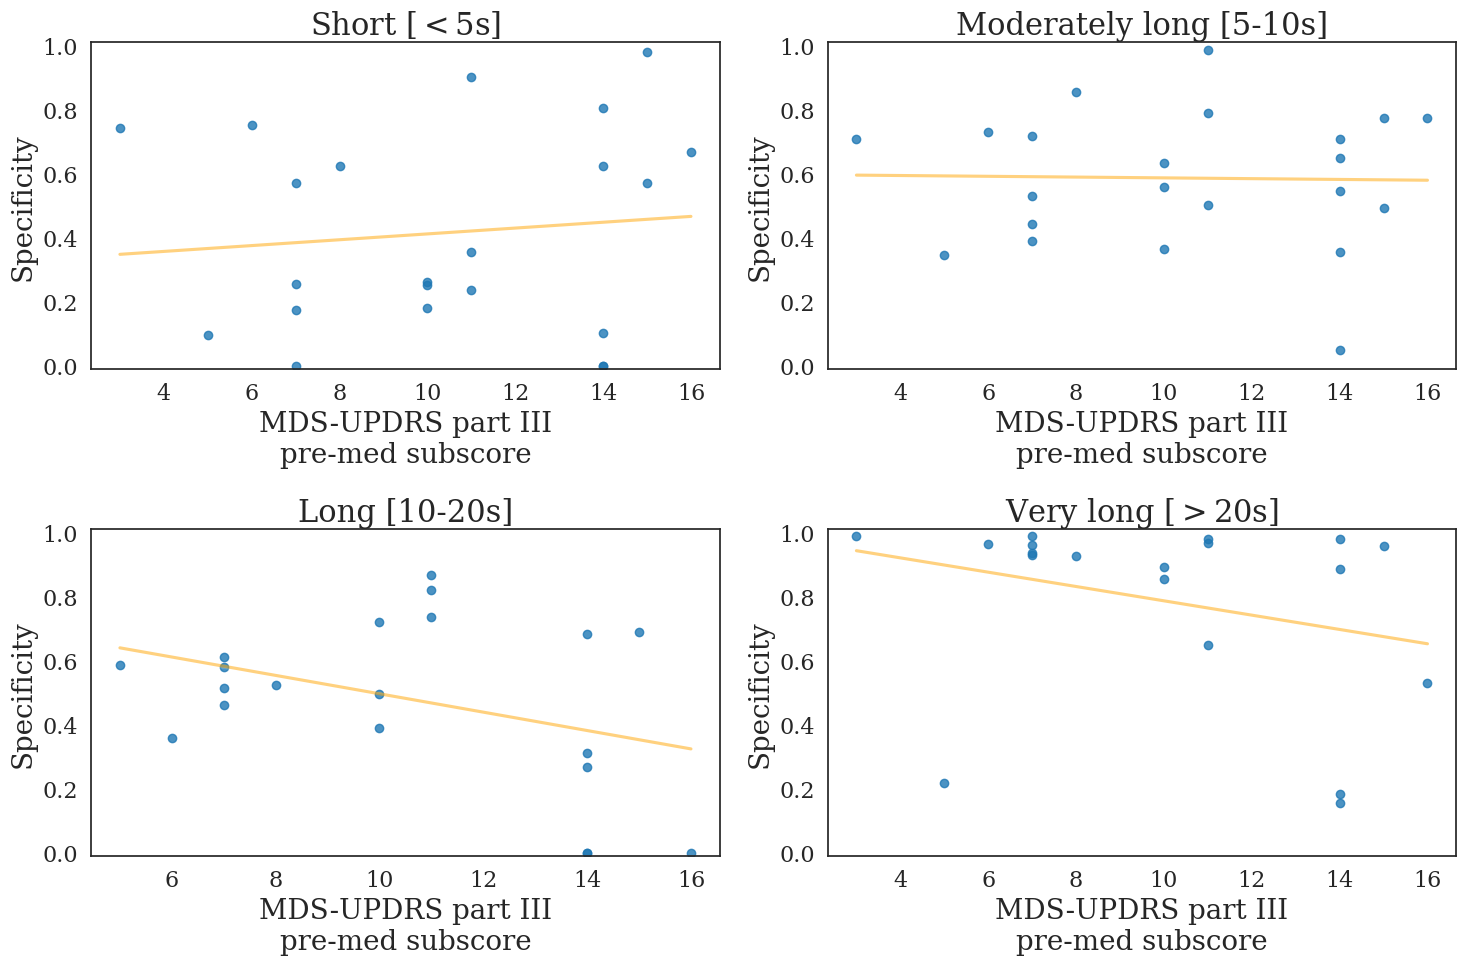

In [23]:
metric = 'spec'

fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(15,10))

affected_side = 'MAS'
med_stage = 'pre'

for j, segment_duration in enumerate(D_SEGMENT_DURATIONS.keys()):

    df_segment_clinical = pd.DataFrame()

    for subject in L_PD_IDS:
        if segment_duration in d_performance[subject][asd_model_selected][affected_side][med_stage]['segment_duration'].keys():
            df_segment_clinical = pd.concat([df_segment_clinical, pd.DataFrame([subject, d_performance[subject][asd_model_selected][affected_side][med_stage]['segment_duration'][segment_duration]['seconds_true_no_other_arm_activity'], d_performance[subject][asd_model_selected][affected_side][med_stage]['segment_duration'][segment_duration][metric], d_performance[subject]['clinical'][med_stage][affected_side]['total'], d_performance[subject]['clinical'][med_stage][affected_side]['subscore']]).T])
            
    df_segment_clinical.columns = [ID_COLNAME, 'seconds_true_no_other_arm_activity', metric, 'total', 'subscore']

    df_segment_clinical['seconds_true_no_other_arm_activity'] = df_segment_clinical['seconds_true_no_other_arm_activity'].astype(float)
    df_segment_clinical[metric] = df_segment_clinical[metric].astype(float)
    df_segment_clinical['total'] = df_segment_clinical['total'].astype(float)
    df_segment_clinical['subscore'] = df_segment_clinical['subscore'].astype(float)

    df_segment_clinical = df_segment_clinical.loc[df_segment_clinical[metric].notna()]

    sns.regplot(x='subscore', y=metric, data=df_segment_clinical, ci=False, scatter_kws={'color': COLOR_PALETTE_SECOND_COLOR}, line_kws={'color': 'orange', 'alpha': 0.5}, marker='o', label='PD patient', ax=ax[j//2,j%2])
    rho = pearsonr(df_segment_clinical[metric], df_segment_clinical['subscore']).statistic
    rho_p = pearsonr(df_segment_clinical[metric], df_segment_clinical['subscore']).pvalue

    zr = np.log((1+rho)/(1-rho))/2
    lower = zr - 1.96/np.sqrt(len(df_segment_clinical)-3)
    upper = zr + 1.96/np.sqrt(len(df_segment_clinical)-3)

    ci = np.tanh(np.array([lower, upper]))

    print(f"{D_SEGMENT_DURATIONS[segment_duration].replace('$', '')} segments: r = {np.round(rho,2)} 95% CI {ci}, p = {rho_p}")

    ax[j//2,j%2].set_title(D_SEGMENT_DURATIONS[segment_duration])
    ax[j//2,j%2].set_ylabel(D_METRIC_MAP[metric])
    ax[j//2,j%2].set_xlabel('MDS-UPDRS part III\npre-med subscore')
    ax[j//2,j%2].set_ylim([-.01,1.01])

fig.tight_layout()

plt.show()

## Supplementary materials

#### Stratified performance

In [44]:
gd_model_selected = RANDOM_FOREST

with open(os.path.join(PDH_PATH_GAIT_PREDICTIONS, 'd_performance_gd.json'), 'r') as f:
    d_performance_gd = json.load(f)

In [46]:
df_subject_results = pd.DataFrame()
affected_side = MOST_AFFECTED_SIDE

for subject in L_PD_IDS:
    for med_stage in ['pre', 'post']:
        for metric in ['sens', 'spec']:
            df_subject = pd.DataFrame([subject,
                                       'Gait detection',
                                       med_stage,
                                       metric,
                                       np.round(d_performance_gd[PARKINSONS_DISEASE][subject][gd_model_selected][affected_side][med_stage][metric],2),
                                        ]).T

            df_subject_results = pd.concat([df_subject_results, df_subject], axis=0).reset_index(drop=True)

            df_subject = pd.DataFrame([subject,
                                       'Filtering gait',
                                       med_stage,
                                       metric,
                                       np.round(d_performance[subject][asd_model_selected][affected_side][med_stage][metric],2),
                                        ]).T
            
            df_subject_results = pd.concat([df_subject_results, df_subject], axis=0).reset_index(drop=True)


df_subject_results.columns = [ID_COLNAME, 'method', 'med_stage', 'metric', 'value']

print("Table 2: Sensitivity (sens) and specificity (spec) of gait detection and filtering gait per PD participant (ID)")
df_subject_results.pivot_table(index=ID_COLNAME, columns=['method', 'med_stage', 'metric'], values='value')

Table 2: Sensitivity (sens) and specificity (spec) of gait detection and filtering gait per PD participant (ID)


method    Filtering gait                   Gait detection                  
med_stage           post         pre                 post         pre      
metric              sens  spec  sens  spec           sens  spec  sens  spec
id                                                                         
hbv002              0.95  0.95  0.88  0.91           0.95  0.94  0.89  0.96
hbv012              0.95  0.73  0.97  0.75           0.85  0.91  0.86   0.9
hbv013              0.89  0.95  0.92  0.51           0.88  0.94  0.69  0.97
hbv014              0.96  0.93  0.82   0.9           0.94  0.96  0.94  0.95
hbv015              0.96  0.66  0.89  0.21           0.98  0.88  0.89  0.93
hbv016              0.81  0.84  0.94  0.64           0.95  0.94  0.94  0.95
hbv017               1.0   0.1  0.98  0.24           0.95  0.96  0.86  0.94
hbv018              0.97   0.6  0.89  0.63           0.95  0.89  0.97  0.88
hbv022              0.93  0.92  0.95  0.85           0.97  0.87  0.94  0.97
hbv023              0.81  0.92  0.89   0.9           0.99  0.91  0.96  0.92
hbv024              0.86  0.84  0.92  0.26           0.97  0.96  0.95  0.96
hbv038               0.6  0.81  0.94  0.54           0.94  0.89  0.58  0.95
hbv039              0.96  0.83  0.99  0.37           0.99  0.96  0.95  0.97
hbv043              0.92  0.79  0.92  0.82           0.96  0.96  0.89  0.96
hbv047              0.83  0.93  0.92  0.81           0.94  0.94  0.87  0.91
hbv054              0.97  0.47  0.95   0.7            0.8  0.96  0.78  0.97
hbv058              0.97  0.98  0.99  0.92           0.97  0.96   0.9  0.98
hbv063              0.89  0.97  0.94  0.95           0.94  0.88  0.89  0.94
hbv065              0.94  0.73  0.94  0.78            0.9  0.97  0.94  0.96
hbv077              0.92  0.98  0.84  0.97           0.99  0.78  0.97  0.96
hbv079               0.9  0.96  0.86  0.93           0.97  0.86  0.94  0.91
hbv090              0.91  0.98  0.92  0.98           0.99  0.83  0.94  0.97